In [1]:
from IPython.core.display import HTML, Markdown, display

import numpy.random as npr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf

import ipywidgets as widgets

# Lab 1: Introduction to Linear Regression

Authored by *Todd Gureckis*  
Aspects borrowed from [General Assembly's Data Science](https://github.com/justmarkham/DAT4) course which claims to have *adapted materials from Chapter 3 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)*

Welcome to the first lab!  You have passed the first part of the class learning the basics of Python and Jupyter with flying colors.  Now you are ready to learn some of the mechanics of running a regression analysis.  In the first part of the lab we'll just cover the details on how to run regressions in Python and some of the conceptual issue involved in the interpretation and fitting of a regression analysis.  Then in the subsequent days of the lab you will put this knowledge to work on a variety of interesting types of data.

<img src="https://imgs.xkcd.com/comics/curve_fitting_2x.png" width="400">

Ok, why are we basing our first lab around the concept of linear regression?  Well it turns out regression (and correlation) are two of the workhorses of a cognitive scientist's toolkit.  Linear regression models are highly interpretable, are used in many places in cognitive science, are fast and simply to perform, and expose some of the basic issues in modeling data.  If there is one tool I use over and over in my work it is linear regression of some type!

Some example uses:
- Often linear regression is used to "control" for nusiance variables in the study that might be confounded.   For example by fitting a linear multiple regression model you can remove the variance in our data attributable to known sources and then model the **residuals** (more on this later).
- The standard analysis techniques for fMRI are based on the General Linear Model which is a kind of generalization of multiple linear regression.  Thus you are getting some of the basics for fMRI analysis.
- Regression is often used to measure latent cognitive variables.  For instance one might be interested in how reaction time changes as a function of task difficulty (e.g., number of distractors present in a task).  Here linear regression is nice because the slope of the regression provides an interprable number which explains how reaction time changes as a function of the task.
- If you were interested in the effect of age on cognitive performance in some task, a linear regression might help you characterize that pattern (although you'd want to check that the linear assumption is valid... more on that later).

Trust me, it is everwhere!

Here's a weird thing you might not know... There is a long running joke/meme about companies that claim to use "machine learning" to analyze data to make "business insights" actually use linear regression (well a special type called logistic regression).  The issue is that complex linear models, particularly multiple linear regression with many input predictors, can mimic a lot of the power of things like neural networks while being more stable, computationally tractable, etc...  So, even if a machine learning company doesn't use linear regression in their final product, often you have to show that your model does **better** than linear regression to be useful.  Thus, linear regression is like the default modeling approach that is often hard to beat!

<img src="images/linear-regression-is-not-machine-learning-is-change-my-mind-45626240.png" width="300">

So you are going to learn some basic machine learning in this lab!  Seriously!  For simplicity we are going to use the [statsmodels](https://www.statsmodels.org/stable/index.html) python package because it has a lot of nice outputs which are helpful for interpreting regressions.  However, you could do almost all of the same stuff using the [scikit-learn](https://scikit-learn.org/stable/) package which is a more general package for machine learning than can perform various types of sophisticated regression, classification, clustering, and dimensionality reduction steps.

## Getting started with some data

Let's get started by loading in some data.  At this point you should be an expert in learning data into a pandas datafrom from a .csv file.  

<div class="alert alert-info" role="alert">
  <strong>Question 1</strong> <br>
    Please load the data set located at <b>http://gureckislab.org/courses/fall19/labincp/data/parenthood.csv</b> into a dataframe called <b>ph_df</b> and inspect the column headers, etc..
</div>

In [2]:
ph_df = pd.read_csv(
    'http://gureckislab.org/courses/fall19/labincp/data/parenthood.csv')
ph_df.head()

,dadsleep,babysleep,dadgrump,day
0,7.59,10.18,56,1
1,7.91,11.66,60,2
2,5.14,7.92,82,3
3,7.71,9.61,55,4
4,6.68,9.75,67,5


You should see that the data contains four columns called **dadsleep**, **babysleep**, **dadgrump**, and **day**.  This is data set created by Danielle Navarrro in her textbook that explores the factors that lead to the dad being grumpy (I have a 1 year old at home so this data is particularly relevant to me!).

<div class="alert alert-info" role="alert">
  <strong>Question 2</strong> <br>
    When we do a regression there are two types of variables.  Some variables are known as features or predictors.  Often a single variable is known as the response variable or the predicted value.  If we are interested in what makes the dad grumpy what are the predictors and what is the response variable?
</div>

The predictors are `babysleep`, `dadsleep`, and `day`. The response variable is `dadgrump`.

Let's look at the data! As we described in the prior labs, the first step of exploratory data analysis is often to look at your data.  

<div class="alert alert-info" role="alert">
  <strong>Question 3</strong> <br>
    Using the seaborn `scatterplot()` command make a scatter plot of how grumpiness changes for each of the three other variables.</div>

<AxesSubplot:xlabel='babysleep', ylabel='dadgrump'>

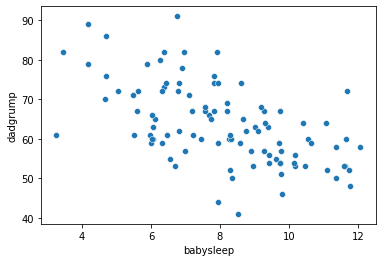

In [3]:
sns.scatterplot(data=ph_df, x='babysleep', y='dadgrump')

<AxesSubplot:xlabel='dadsleep', ylabel='dadgrump'>

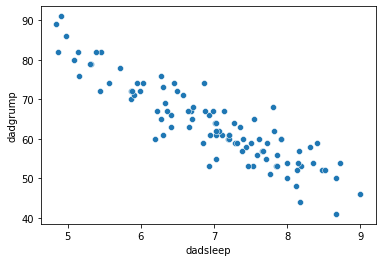

In [4]:
sns.scatterplot(data=ph_df, x='dadsleep', y='dadgrump')

<AxesSubplot:xlabel='day', ylabel='dadgrump'>

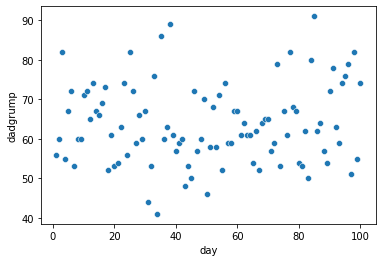

In [5]:
sns.scatterplot(data=ph_df, x='day', y='dadgrump')

<div class="alert alert-info" role="alert">
  <strong>Question 4</strong> <br>
    Based on your exploratory view of the data what do you think are the relationship within this data set?
</div>

According to the view, there is little correlation between `day` and `dadgrump`, small negative correlation between `babysleep` and `dadgrump`, and large negative correlation between `dadsleep` and `dadgrump`.

## Simple Linear Regression

Simple linear regression is an approach for predicting a **quantitative response** using a **single feature** (or "predictor" or "input variable"). It takes the following form:

$y = \beta_0 + \beta_1x$

What does each term represent?
- $y$ is the response
- $x$ is the feature
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for x

Together, $\beta_0$ and $\beta_1$ are called the **model coefficients**. To create your model, you must "learn" the values of these coefficients. And once we've learned these coefficients, we can use the model to make predictions!

What do you mean by "learn"?  Well you are probably more familiar with the phrase "fit" meaning we adjust the settings of the model coefficients (aka as parameters) until the line seems like a good summary of the data.  Fitting thus mean adjusting some internal numbers so that the better reflect the underlying data set.  Well when a human (or machine) learns it, it is in some sense of the same thing.  We change the connections of the weights (or parameters) inside our brains to help us better predict our environment.  For instance if your roommate is prone to late night partying and being grumpy the next day you might mentally fit a model to the experiences you have and "learn" what features are predictive of them being grumpy.  So basically fitting a linear regression model is the same as doing basic machine learning! Wow!

## Manipulate the fitting by hand

Before we get into using the computer to "fit" our data, let's start simple and do things by hand.

In [6]:
@widgets.interact(slope=widgets.IntSlider(min=-20, max=20, step=1, value=0),
                  intercept=widgets.IntSlider(min=0, max=200, step=1,
                                              value=50))
def plot_grumpiness(slope, intercept):
    predict = intercept - slope * ph_df.dadsleep
    resid = ph_df.dadgrump - predict
    fig, ax = plt.subplots(figsize=(9, 6))

    x1 = np.linspace(ph_df.dadsleep.min(), ph_df.dadsleep.max(), 400)
    y1 = intercept - slope * x1

    ax.plot(ph_df.dadsleep, ph_df.dadgrump, 'ko', markersize=4)
    #ax.plot(ph_df.dadsleep, ph_df.dadgrump-resid,'o',markersize=4,markeredgecolor='r', markeredgewidth=.4, markerfacecolor='white')

    ax.plot(x1, y1, '-', color='steelblue', linewidth=1)
    plt.xlabel("dad sleep")
    plt.ylabel("dad grumpiness")

    #ax.vlines(ph_df.dadsleep, ph_df.dadgrump, ph_df.dadgrump-resid,'r',linewidth=0.5)
    plt.show()

interactive(children=(IntSlider(value=0, description='slope', max=20, min=-20), IntSlider(value=50, descriptio…

<div class="alert alert-info" role="alert">
  <strong>Question 5</strong> <br>
    Using the slider above, adjust the location of the line to best fit the data represented by the black dots.  What value did you get for the slope and intercept?
</div>

I got 10 for the slope and 133 for the intercept so that the line looks well fit the data.

The next plot show what are known as the **residuals** between the actual data points (black) and the regression line (blue).  As you can see the total amount of red changes depending on which line you use.  

In [7]:
@widgets.interact(slope=widgets.IntSlider(min=-20, max=20, step=1, value=0),
                  intercept=widgets.IntSlider(min=0, max=200, step=1,
                                              value=50))
def plot_grumpiness(slope, intercept):
    predict = intercept - slope * ph_df.dadsleep
    resid = ph_df.dadgrump - predict
    fig, ax = plt.subplots(figsize=(9, 6))

    x1 = np.linspace(ph_df.dadsleep.min(), ph_df.dadsleep.max(), 400)
    y1 = intercept - slope * x1

    ax.plot(ph_df.dadsleep, ph_df.dadgrump, 'ko', markersize=4)
    ax.plot(ph_df.dadsleep,
            ph_df.dadgrump - resid,
            'o',
            markersize=4,
            markeredgecolor='r',
            markeredgewidth=.4,
            markerfacecolor='white')

    ax.plot(x1, y1, '-', color='steelblue', linewidth=1)
    plt.xlabel("dad sleep")
    plt.ylabel("dad grumpiness")

    ax.vlines(ph_df.dadsleep,
              ph_df.dadgrump,
              ph_df.dadgrump - resid,
              'r',
              linewidth=0.5)
    plt.show()

interactive(children=(IntSlider(value=0, description='slope', max=20, min=-20), IntSlider(value=50, descriptio…

<div class="alert alert-info" role="alert">
  <strong>Question 6</strong> <br>
    Find the best fit line you found from the plot above and compare it to different settings of the parameters.  What do you notice about the lines that seem to fit well and the overall amount of red lines in the plot?
</div>

The lines that seem to fit well have the smallest overall amount of red lines in the plot.

## Estimating ("Learning") Model Coefficients

The mechanics of fitting a line to some data (aka as "learning" the model coefficients or parameters) is best left to the computer.  The reason is that for some dataset what is the "best fit" line might end up being too subjective (different people would prefer a different line).  Also when we get to doing fMRI analysis you might repeat the regression for hundreds of thousands of individual voxels.  This would take a lot of tinkering by hand to solve.

Generally speaking, coefficients are estimated using the **least squares criterion**, which means we are find the line (mathematically) which minimizes the **sum of squared residuals** (or "sum of squared errors"):

<img src="images/08_estimating_coefficients.png" width="600">

What elements are present in the diagram?
- The black dots are the **observed values** of x and y.
- The blue line is our **least squares line**.
- The red lines are the **residuals**, which are the distances between the observed values and the least squares line.

How do the model coefficients relate to the least squares line?
- $\beta_0$ is the **intercept** (the value of $y$ when $x$=0)
- $\beta_1$ is the **slope** (the change in $y$ divided by change in $x$)

Here is a graphical depiction of those calculations:

<img src="images/08_slope_intercept.png" width="450">

Let's use the **statmodels** python package to estimate the model coefficients (aka "fit" the model) instead!

In [8]:
# this is the standard import if you're using "formula notation" (similar to R)
import statsmodels.formula.api as smf

# create the fitted model in one line
lm = smf.ols(formula='dadgrump ~ dadsleep', data=ph_df).fit()

print(lm.params)

Intercept    125.956292
dadsleep      -8.936756
dtype: float64


A couple of points here... First is that we use the `smf.ols()` function which does an "ordinary least squares" fit.  This is the type of fit which tries to minimze the sum of the squared residuals.  There are other types of fitting proceedures such as weighted least squares which is used when you expect the variance of the predicted variable to changes with the input predictor as well as its mean value.  We don't worry abou that for this class though.

The second is that we provide the `ols()` function with the pandas dataframe we are working with (`ph_df` according to the instructions in the first step of the lab) and then provide a formula.  The formula expresses our "model" and is which variables in the data frame we are trying to relate.  Here the formula `dadgrump ~ dadsleep` means that we want to predict `dadgrump` values given `dadsleep` values.  So you think of `dadgrump` as our "y value" and `dadsleep` are our x value. 

<div class="alert alert-info" role="alert">
  <strong>Question 7</strong> <br>
    Look at the output parameters from the ols fitting proceedure.  How do they compare to the ones you fitted by hand?
</div>

The parameters are close but not the same, and it's expected that the ones produced by ols fitting procedure would have the smallest sum of squared residuals.

## Interpret an OLS Regression fit

Ok, so we did a model fit.  We are like totally machine learning experiments now since we taught a model!  But the cool thing about linear regression is that the model strucutre is *easily interpretable*.  So what can we learn from the fit?

### Interpreting Model Coefficients

How do we interpret the `dadsleep` coefficient?
- A "unit" increase in hours data sleep is **associated with** a -8.9367 "unit" decrease (because it is negative) in grumpiness.  This kind of make sense. More sleep = less grumpy!


Note that if an increase in sleep was associated with a **increase** in grumpiness, the `dadsleep` coefficient would be **positive**.

The `Intercept` coefficent is 125.95.  This means that if dad gets no sleep at all his grumpiness will be at a very high level of 125.95!  Bad news.

## Using the Model for Prediction

Let's say that mom comes into the picture here.  Mom wants to anticipate how grumpy dad will be today.  So she measures his sleep last night and finds that he slept 6 hours.  What is her best guess about what the grumpiness level will be today?

Well she could go back to the data and find a similar day where dad got 6 hours of sleep and average those together or grab one at random and repeat the same guess.  However, since we just fit our linear regression equation we can use that model for prediction.  In particular, remember:

$$y = \beta_0 + \beta_1x$$
$$y = 125.956292 + -8.936756 \times 6$$

<div class="alert alert-info" role="alert">
  <strong>Question 8</strong> <br>
    Use your python calculator skills to predict the level of grumpiness for a dad who got 6 hours of sleep.  Why is using the regression line a better way to make predictions than to grab similar cases and just use those?
</div>

In [9]:
125.956292 - 8.936756 * 6

72.335756

In [10]:
ph_df[(ph_df.dadsleep < 6.5) & (ph_df.dadsleep > 5.5)]['dadgrump'].mean()

70.0

Although we get a similar value here by averaging the similar cases, it's not always true, as we don't know if it's always following a linear relationship and similar but not the same predictors might result in a totally different outcome. Taking the average will also not minimize the prediction error, e.g., squared residuals.

Of course, we can also use Statsmodels to make the prediction:

In [11]:
# you have to create a DataFrame since the Statsmodels formula interface expects it
X_new = pd.DataFrame({'dadsleep': [6]})
X_new.head()

,dadsleep
0,6


In [12]:
lm.predict(X_new)

0    72.335757
dtype: float64

## Plotting the least squares regression line

Let's take a look at the best fit line.  There are two very easy ways to do this.  One is using seaborn's regplot which includes within the function an entire step to plot the regression line:

<AxesSubplot:xlabel='dadgrump', ylabel='dadsleep'>

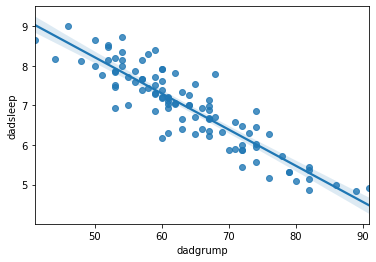

In [13]:
%%capture --no-display
sns.regplot('dadgrump', 'dadsleep', data=ph_df)

Alternatively if we are concerned the maybe we don't understand exactly what seaborn is doing we can plot the output of our fit from the `ols()` command:

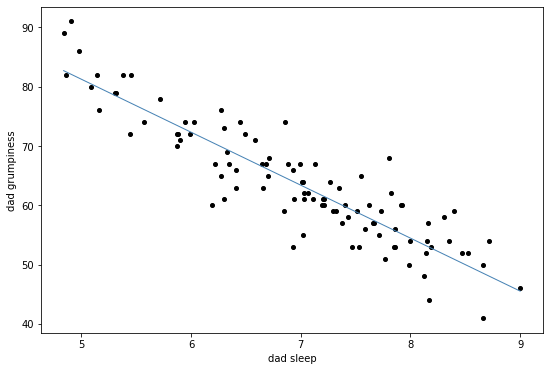

In [14]:
fig, ax = plt.subplots(figsize=(9, 6))

# create a DataFrame with the minimum and maximum values of sleep
x1 = pd.DataFrame({'dadsleep': [ph_df.dadsleep.min(), ph_df.dadsleep.max()]})
y1 = lm.predict(
    x1)  # predict for the two data points using the fitted model in lm

ax.plot(ph_df.dadsleep, ph_df.dadgrump, 'ko', markersize=4)

ax.plot(x1, y1, '-', color='steelblue', linewidth=1)
plt.xlabel("dad sleep")
plt.ylabel("dad grumpiness")

plt.show()

## Confidence in our Model

Statsmodels calculates 95% confidence intervals for our model coefficients, which are interpreted as follows: If the population from which this sample was drawn was **sampled 100 times**, approximately **95 of those confidence intervals** would contain the "true" coefficient.

In [15]:
# print the confidence intervals for the model coefficients
lm.conf_int()

,0,1
Intercept,119.971000,131.941583
dadsleep,-9.787161,-8.086350


Keep in mind that we only have a **single sample of data**, and not the **entire population of data**. The "true" coefficient is either within this interval or it isn't, but there's no way to actually know. We estimate the coefficient with the data we do have, and we show uncertainty about that estimate by giving a range that the coefficient is **probably** within.

Note that using 95% confidence intervals is just a convention. You can create 90% confidence intervals **(which will be more narrow)**, 99% confidence intervals **(which will be wider)**, or whatever intervals you like.

## Hypothesis Testing and p-values

Closely related to confidence intervals is **hypothesis testing**. Generally speaking, you start with a **null hypothesis** and an **alternative hypothesis** (that is opposite the null). Then, you check whether the data supports **rejecting the null hypothesis** or **failing to reject the null hypothesis**.

(Note that "failing to reject" the null is not the same as "accepting" the null hypothesis. The alternative hypothesis may indeed be true, except that you just don't have enough data to show that.)

As it relates to model coefficients, here is the conventional hypothesis test:
- **null hypothesis:** There is no relationship between dad sleep and grumpiness (and thus $\beta_1$ equals zero)
- **alternative hypothesis:** There is a relationship between dad sleep and dad grumpinss (and thus $\beta_1$ is not equal to zero)

How do we test this hypothesis? Intuitively, we reject the null (and thus believe the alternative) if the 95% confidence interval **does not include zero**. Conversely, the **p-value** represents the probability that the coefficient is actually zero:

In [16]:
# print the p-values for the model coefficients
lm.pvalues

Intercept    3.070709e-64
dadsleep     8.176426e-38
dtype: float64

If the 95% confidence interval **includes zero**, the p-value for that coefficient will be **greater than 0.05**. If the 95% confidence interval **does not include zero**, the p-value will be **less than 0.05**. Thus, a p-value less than 0.05 is one way to decide whether there is likely a relationship between the feature and the response. (Again, using 0.05 as the cutoff is just a convention.)

In this case, the p-value for dad sleep is far less than 0.05, and so we **believe** that there is a relationship between sleep and grumpiness.

Note that we generally ignore the p-value for the intercept.

## How Well Does the Model Fit the data?

The most common way to evaluate the overall fit of a linear model is by the **R-squared** value. R-squared is the **proportion of variance explained**, meaning the proportion of variance in the observed data that is explained by the model, or the reduction in error over the **null model**. (The null model just predicts the mean of the observed response, and thus it has an intercept and no slope.)

R-squared is between 0 and 1, and higher is better because it means that more variance is explained by the model. Here's an example of what R-squared "looks like" fit to a different dataset:

<img src="images/08_r_squared.png" width="500">

You can see that the **blue line** explains some of the variance in the data (R-squared=0.54), the **green line** explains more of the variance (R-squared=0.64), and the **red line** fits the training data even further (R-squared=0.66). (Does the red line look like it's overfitting?)

Let's calculate the R-squared value for our simple linear model:

In [17]:
# print the R-squared value for the model
lm.rsquared

0.816102719147878

Is that a "good" R-squared value? It's hard to say. The threshold for a good R-squared value depends widely on the domain. Therefore, it's most useful as a tool for **comparing different models**.

<img src="https://imgs.xkcd.com/comics/linear_regression_2x.png" width="300">

So far we have been pulling information from our fitted model piece by piece.  However, there is a nice summary command that lets you access a bunch of information about your regression at once.

In [18]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               dadgrump   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     434.9
Date:                Tue, 04 May 2021   Prob (F-statistic):           8.18e-38
Time:                        20:43:47   Log-Likelihood:                -287.48
No. Observations:                 100   AIC:                             579.0
Df Residuals:                      98   BIC:                             584.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    125.9563      3.016     41.762      0.000     119.971     131.942
dadsleep      -8.9368      0.429    -20.854      0.000      -9.787      -8.086
==============================================================================
Omnibus:                        0.597   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.742   Jarque-Bera (JB):                0.221
Skew:                          -0.054   Prob(JB):                        0.895
Kurtosis:                       3.204   Cond. No.                         50.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This include most of the numbers we discussed above and a few more things discussed in the book chapter reading on regression.

<div class="alert alert-info" role="alert">
  <strong>Question 9</strong> <br>
    You know know the basics of linear regression! Congrats.  Now I want you to work on analyzing a new data set in the same way.  All the pieces you need are above or we have encountered in previous lab.  Please obtain the dataset on advertising available as a CSV here: http://gureckislab.org/courses/fall19/labincp/data/advertising.csv
    
<ul>
<li>Read in the data frame</li>
<li>Look at the structure of the columns (note the column names are case sensitive)</li>
<li>Plot the relationship between TV advertising and Sale, the relationship between Radio and Sales, and the relationship between Newspaper and Sales.  What does this visual exploration of the data suggest? (bonus if you can use subplots() to make it a single figure)</li>
<li>Perform a separate simple OLS regression of each of the three feature sets on the response variable.  Remember that you might want to call your variables different names to keep things separate.  For isntance instead of storing the result of each regression in a varable called <b>lm</b> you might want a different lm variable names for each of the simple regressions you run</li>
<li>Plot the best fit line for each of the three patterns</li>
<li>Describe the best fitting parameters for each of the three dataset.  What are the coefficients in each model, are the slopes different than zero (given the hypothesis test)?  What is the R^2 value?</li>
<li>In a markdown cell write a brief summary of what you think is going on in this data.  What types of advertising are most effective for sales?  If you had a limited budget which one would you focus your advertising dollars on?</li>

</ul>
</div>

A hint: what are the **features**?
- TV: advertising dollars spent on TV for a single product in a given market (in thousands of dollars)
- Radio: advertising dollars spent on Radio
- Newspaper: advertising dollars spent on Newspaper

What is the **response**?
- Sales: sales of a single product in a given market (in thousands of widgets)

In [19]:
ad_df = pd.read_csv(
    'http://gureckislab.org/courses/fall19/labincp/data/advertising.csv')
ad_df.head()

,index,tv,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


<AxesSubplot:xlabel='newspaper', ylabel='sales'>

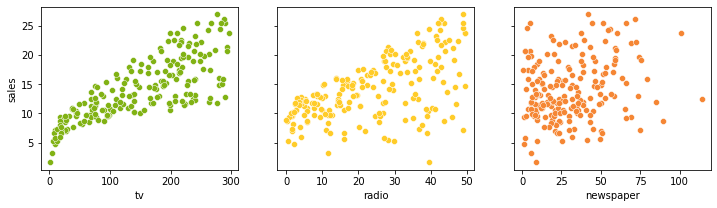

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
sns.scatterplot(data=ad_df, x='tv', y='sales', ax=axs[0], color='#81b214')
sns.scatterplot(data=ad_df, x='radio', y='sales', ax=axs[1], color='#ffcc29')
sns.scatterplot(data=ad_df,
                x='newspaper',
                y='sales',
                ax=axs[2],
                color='#f58634')

Visually, there's a strong correlation between `tv` and `sales`, a moderate correlation between `radio` and `sales`, and a small or none correlation between `newspaper` and `sales`.

In [21]:
lm_tv = smf.ols(formula='sales ~ tv', data=ad_df).fit()
lm_rd = smf.ols(formula='sales ~ radio', data=ad_df).fit()
lm_np = smf.ols(formula='sales ~ newspaper', data=ad_df).fit()
print(lm_tv.params)
print(lm_rd.params)
print(lm_np.params)

Intercept    7.032594
tv           0.047537
dtype: float64
Intercept    9.311638
radio        0.202496
dtype: float64
Intercept    12.351407
newspaper     0.054693
dtype: float64


<AxesSubplot:xlabel='newspaper', ylabel='sales'>

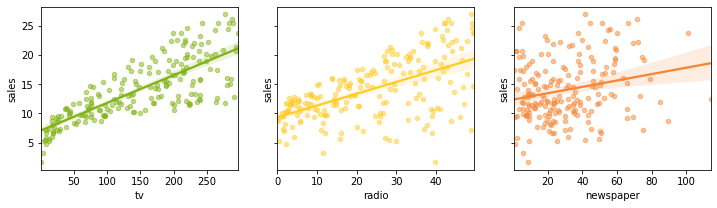

In [22]:
%%capture --no-display
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
sns.regplot('tv',
            'sales',
            data=ad_df,
            ax=axs[0],
            color='#81b214',
            scatter_kws={
                's': 20,
                'alpha': 0.5
            })
sns.regplot('radio',
            'sales',
            data=ad_df,
            ax=axs[1],
            color='#ffcc29',
            scatter_kws={
                's': 20,
                'alpha': 0.5
            })
sns.regplot('newspaper',
            'sales',
            data=ad_df,
            ax=axs[2],
            color='#f58634',
            scatter_kws={
                's': 20,
                'alpha': 0.5
            })

### Fitting Parameters

- A "unit" increase in TV advertisement is associated with a 0.047537 "unit" increase in sales.
- A "unit" increase in radio advertisement is associated with a 0.202496 "unit" increase in sales.
- A "unit" increase in newspaper advertisement is associated with a 0.054693 "unit" increase in sales.

### Confidence Intervals

In [23]:
print(lm_tv.conf_int())
print(lm_rd.conf_int())
print(lm_np.conf_int())

                  0         1
Intercept  6.129719  7.935468
tv         0.042231  0.052843
                  0          1
Intercept  8.201588  10.421688
radio      0.162244   0.242747
                   0          1
Intercept  11.125956  13.576859
newspaper   0.022005   0.087381


None of the CI includes the zero.

### Hypothesis Testing and p-values

In [24]:
print(lm_tv.pvalues)
print(lm_rd.pvalues)
print(lm_np.pvalues)

Intercept    1.406300e-35
tv           1.467390e-42
dtype: float64
Intercept    3.561071e-39
radio        4.354966e-19
dtype: float64
Intercept    4.713507e-49
newspaper    1.148196e-03
dtype: float64


All of the p-values are far smaller than our 0.05 cutoff. Thus, we reject all null hypothesis that each of these advertisement methods has no association with the final sales.

### $R^2$

In [25]:
print(lm_tv.rsquared)
print(lm_rd.rsquared)
print(lm_np.rsquared)

0.611875050850071
0.33203245544529547
0.05212044544430516


We can tell that the model for TV and radio accounts for a lot more variety than the one for newspaper.

### Summery

The data describes the relationship between the advertisement media and the sales record. All three advertisement media have a positive correlation with the sales, while the TV's is the strongest and the newspaper's is the weakest. However, the most effective one is the radio's - one unit of increase results in the most unit of increase in sales. If one has a limited budget, then they should focus on the radio advertisement.